In [1]:
%load_ext autoreload
import ddls

In [2]:
from ddls.devices.processors.gpus.A100 import A100
from ddls.distributions.uniform import Uniform

node_config = {'type_1':
                  {
                      'num_nodes': 16, # 64
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4, # 8
                          'y_dims': 4, # 8
                          'num_channels': 4,
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}

Cluster <class 'ddls.environments.ramp_cluster.ramp_cluster_environment.RampClusterEnvironment'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4, 'num_channels': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


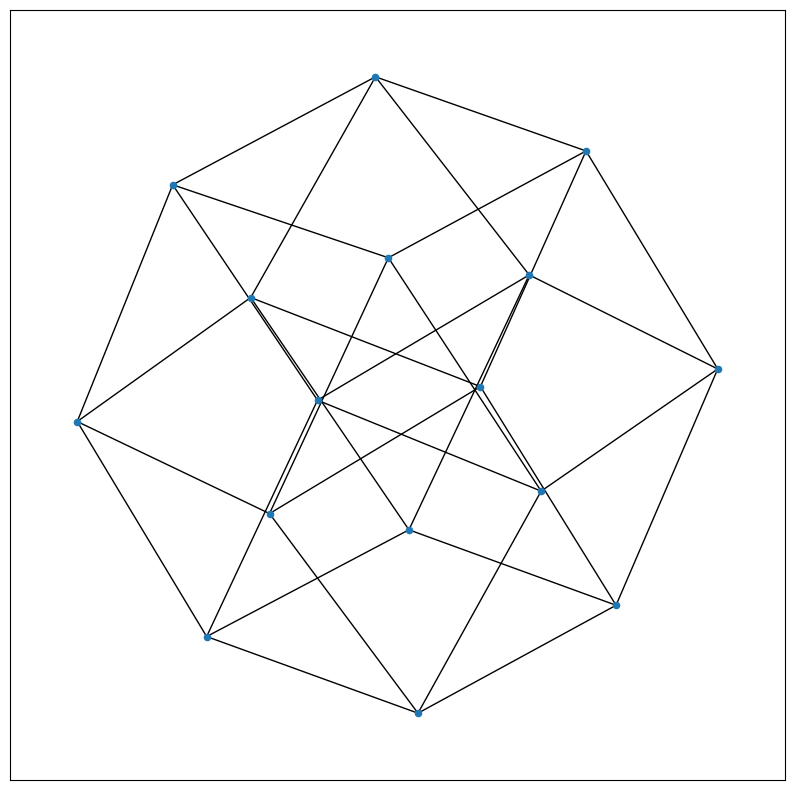

Node 1-1-1: {'workers': {'node_1-1-1_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fdd30>, 'node_1-1-1_worker_1': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1dc44fd00>, 'node_1-1-1_worker_2': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fdd60>, 'node_1-1-1_worker_3': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fdd90>}}
Node 2-1-1: {'workers': {'node_2-1-1_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fd040>, 'node_2-1-1_worker_1': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1dc490fa0>, 'node_2-1-1_worker_2': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fde20>, 'node_2-1-1_worker_3': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fde50>}}
Node 3-1-1: {'workers': {'node_3-1-1_worker_0': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fddc0>, 'node_3-1-1_worker_1': <ddls.devices.processors.gpus.A100.A100 object at 0x7fb1163fddf0>, 'node_3-1-1_worker_2': 

In [3]:
%autoreload
from ddls.environments.ramp_cluster.ramp_cluster_environment import RampClusterEnvironment

env = RampClusterEnvironment(topology_config=topology_config,
                             node_config=node_config,
#                              path_to_save='/scratch/datasets/ddls/sims',
                             save_freq=100,
                             use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

In [4]:
%autoreload
from ddls.environments.ramp_cluster.agents.placers.random_op_placer import RandomOpPlacer
from ddls.environments.ramp_cluster.agents.schedulers.srpt_op_scheduler import SRPTOpScheduler
from ddls.environments.ramp_cluster.agents.placers.first_fit_dep_placer import FirstFitDepPlacer
from ddls.environments.ramp_cluster.agents.schedulers.srpt_dep_scheduler import SRPTDepScheduler

control_plane = {
    'op_placer': RandomOpPlacer(),
    'op_scheduler': SRPTOpScheduler(),
    'dep_placer': FirstFitDepPlacer(),
    'dep_scheduler': SRPTDepScheduler()
}

In [11]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally
from ddls.environments.ramp_cluster.actions.action import Action

import time
import pprint


# seeds = [0, 1, 2]
seeds = [0]
verbose = True

for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs = env.reset(jobs_config=jobs_config,
                    max_simulation_run_time=float('inf'),
                    job_queue_capacity=10,
                    seed=seed,
                    verbose=True)
    
    done = False
    start_time = time.time()
    while not done:
        # make decisions
        op_placement = control_plane['op_placer'].get(cluster=env)        
        op_schedule = control_plane['op_scheduler'].get(op_placement=op_placement, cluster=env)        
        dep_placement = control_plane['dep_placer'].get(op_placement=op_placement, cluster=env)        
        dep_schedule = control_plane['dep_scheduler'].get(dep_placement=dep_placement, cluster=env)
        
        # syncronise decisions into class of valid actions
        action = Action(op_placement=op_placement,
                        op_schedule=op_schedule,
                        dep_placement=dep_placement,
                        dep_schedule=dep_schedule)
        print(f'action: {action}')
            
        raise Exception()
            
        # pass actions to cluster environment and step the cluster
        obs, action_set, reward, done, info = env.step(op_placement=op_placement,
                                                       op_schedule=op_schedule,
                                                       dep_placement=dep_placement,
                                                       dep_schedule=dep_schedule,
                                                       verbose=verbose)
        if not verbose:
            print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')
    
    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Reset cluster environment.
Max sim run time: inf
action: 
op_placement:
	Job ID: 140398557928512
		Op ID 0 -> Worker ID node_1-1-1_worker_1
		Op ID 1 -> Worker ID node_2-3-1_worker_2
		Op ID 2 -> Worker ID node_1-3-1_worker_3
		Op ID 3 -> Worker ID node_3-1-1_worker_0
		Op ID 4 -> Worker ID node_2-3-1_worker_1
		Op ID 5 -> Worker ID node_1-4-1_worker_2
		Op ID 6 -> Worker ID node_3-2-1_worker_3
		Op ID 7 -> Worker ID node_2-2-1_worker_3
		Op ID 8 -> Worker ID node_3-1-1_worker_2
		Op ID 9 -> Worker ID node_4-1-1_worker_3
		Op ID 10 -> Worker ID node_1-3-1_worker_1
		Op ID 11 -> Worker ID node_1-3-1_worker_0
		Op ID 12 -> Worker ID node_1-3-1_worker_1
		Op ID 13 -> Worker ID node_2-1-1_worker_3
		Op ID 14 -> Worker ID node_2-4-1_worker_1
		Op ID 15 -> Worker ID node_4-1-1_worker_1
		Op ID 16 -> Worker ID node_4-3-1_worker_1
		Op ID 17 -> Worker ID node_2-1-1_worker_3
		Op ID 18 -> Worker ID node_1-2-1_worker_3
		Op ID 19 -> Worke

Exception: 